**First International Summer School in Data Science for Mobility (DSM)**, 3-7 October 2022, Santorini, Greece

<img width=200, src="http://master-school.isti.cnr.it/wp-content/uploads/2022/05/logo-Summer-School-Mobility-2022.png"/>

Author: [Luca Pappalardo](https://twitter.com/lucpappalard)

# Flow generation models

## Train a Gravity model in San Francisco to predict flows in Denver

1. Download checkin data and create a `TrajDataFrame`
1. Create square tessellations for the two cities
1. Compute the relevance of each tile
1. Create `FlowDataFrame`s aggregating `TrajDataFrame`s 
5. Compute the total number of trips from each tile
6. Fit a singly-constrained Gravity using trips in San Francisco
7. Use the fitted model to predict flows in Denver


8. **Qualitative evaluation**: visualise the performance of the model against a baseline random model
9. **Quantitative evaluation**: compute performance metrics

## The Gravity model of human mobility

$T_{ij} \propto \frac{pop_i^{\alpha_1} \cdot pop_j^{\alpha_2}}{r_{ij}^\beta}$

In [45]:
import skmob
from skmob.utils import utils, constants
from skmob.tessellation import tilers
from skmob.utils.plot import plot_gdf

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import folium
from folium.plugins import HeatMap
import matplotlib as mpl
import matplotlib.pyplot as plt

### Create a `TrajDataFrame` from <a href="https://snap.stanford.edu/data/loc-brightkite.html">Brightkite</a> checkins

In [46]:
# first download checkins using pandas
url = "https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz"
df = pd.read_csv(url, sep='\t', header=0, nrows=100000, 
                 names=['user', 'check-in_time', 'latitude', 'longitude', 'location id'])

In [47]:
# convert the DataFrame into a TrajDataFrame
tdf = skmob.TrajDataFrame(df, latitude='latitude', longitude='longitude', datetime='check-in_time', user_id='user')
tdf.crs = 'epsg:4326'
print('number of rows: %s' %len(tdf))
print(type(tdf))
tdf.head()

number of rows: 100000
<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


uid                  datetime        lat         lng  \
0    0 2010-10-16 06:02:04+00:00  39.891383 -105.070814   
1    0 2010-10-16 03:48:54+00:00  39.891077 -105.068532   
2    0 2010-10-14 18:25:51+00:00  39.750469 -104.999073   
3    0 2010-10-14 00:21:47+00:00  39.752713 -104.996337   
4    0 2010-10-13 23:31:51+00:00  39.752508 -104.996637   

                                location id  
0          7a0f88982aa015062b95e3b4843f9ca2  
1          dd7cd3d264c2d063832db506fba8bf79  
2  9848afcc62e500a01cf6fbf24b797732f8963683  
3          2ef143e12038c870038df53e0478cefc  
4          424eb3dd143292f9e013efa00486c907

In [48]:
tdf.plot_trajectory(max_users=10, max_points=1000, zoom=4, start_end_markers=False)

/Users/lucapappalardo/opt/anaconda3/envs/GSA/lib/python3.9/site-packages/skmob/core/trajectorydataframe.py:569: UserWarning: If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.
  return plot.plot_trajectory(self, map_f=map_f, max_users=max_users, max_points=max_points, style_function=style_function,


In [49]:
m = folium.Map(tiles='openstreetmap', zoom_start=12, control_scale=True)
HeatMap(tdf[:50000][['lat', 'lng']].values).add_to(m)
m

### Create square tessellations

#### Training city: San Francisco

In [55]:
from skmob.utils.plot import plot_gdf

In [54]:
# it retrieve information from the web
tess_train = tilers.tiler.get("squared",  
                              base_shape="San Francisco, California", 
                              meters=2500)
len(tess_train)

207

In [58]:
plot_gdf(tess_train, zoom=10)

#### Test city: Denver

In [59]:
tess_test = tilers.tiler.get("squared", meters=2500, 
                             base_shape="Denver, Colorado")
len(tess_test)

159

In [62]:
plot_gdf(tess_test, zoom=10)

### Compute the relevance of each tile


1. assign each point to the corresponding tile in San Francisco

In [63]:
tdf_tid = tdf.mapping(tess_train, remove_na=True)
tdf_tid.head(3)

/Users/lucapappalardo/opt/anaconda3/envs/GSA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


uid                  datetime        lat         lng  \
347    0 2010-05-07 02:46:58+00:00  37.785078 -122.404998   
348    0 2010-05-07 02:43:54+00:00  37.785078 -122.404998   
349    0 2010-05-07 02:12:09+00:00  37.790254 -122.407277   

                                  location id tile_ID  
347  8d788309d5057922a69ea575f8fc4ea7acbab45c     162  
348  8d788309d5057922a69ea575f8fc4ea7acbab45c     162  
349          a53d39a2ef3611dd970d003048c10834     162

2. compute the relevance of each tile in San Francisco

In [64]:
relevances = tdf_tid.groupby(by='tile_ID').count()[['lat']].rename(
    columns={'lat': 'relevance'})
relevances /= relevances.sum() # normalize

tess_train = tess_train.merge(relevances, right_index=True, left_on='tile_ID', how='left').fillna(0.)
tess_train.head(3)

tile_ID                                           geometry  relevance
0       0  POLYGON ((-123.17383 37.72918, -123.17383 37.7...        0.0
1       1  POLYGON ((-123.17383 37.74694, -123.17383 37.7...        0.0
2       2  POLYGON ((-123.17383 37.76469, -123.17383 37.7...        0.0

Do the same for Denver

In [65]:
tdf_tid = tdf.mapping(tess_test, remove_na=True)
relevances = tdf_tid.groupby(by='tile_ID').count()[['lat']].rename(columns={'lat': 'relevance'})
# normalise
relevances /= relevances.sum()

tess_test = tess_test.merge(relevances, right_index=True, left_on='tile_ID', how='left').fillna(0.)
tess_test.head(3)

/Users/lucapappalardo/opt/anaconda3/envs/GSA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


tile_ID                                           geometry  relevance
0       0  POLYGON ((-105.10988 39.61432, -105.10988 39.6...    0.00047
1       1  POLYGON ((-105.10988 39.63161, -105.10988 39.6...    0.00000
2       2  POLYGON ((-105.08743 39.61432, -105.08743 39.6...    0.00000

In [68]:
def define_colormap(tessellation, minval=1e-6):
    # define the colormap
    normc = mpl.colors.LogNorm(vmin=max(tessellation['relevance'].min(), minval), \
                               vmax=tessellation['relevance'].max())
    s_m = mpl.cm.ScalarMappable(cmap='jet', norm=normc)
    return s_m

def get_color(x):
    return mpl.colors.to_hex(s_m.to_rgba(x['relevance'] + 1e-12))

In [69]:
s_m = define_colormap(tess_train)
plot_gdf(tess_train, zoom=10, popup_features=['relevance'], \
         style_func_args={'color': get_color, 'fillColor' : get_color})

In [70]:
# the same for Denver
s_m = define_colormap(tess_test)
plot_gdf(tess_test, zoom=10, popup_features=['relevance'], \
         style_func_args={'color': get_color, 'fillColor' : get_color})

### Create `FlowDataFrame`s 

In [71]:
# for San Francisco
fdf_train = tdf.to_flowdataframe(tess_train, self_loops=False)
print(fdf_train['flow'].sum(), fdf_train['flow'].max())
fdf_train.head(4)

/var/folders/l4/n69k0p694d95z18vym8s17xm0000gn/T/ipykernel_29041/2071213720.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  fdf_train = tdf.to_flowdataframe(tess_train, self_loops=False)


1671 144


origin destination  flow
1    111         137     1
3    112         137     1
4    112         146     1
5    112         161     2

In [72]:
# for Denver
fdf_test = tdf.to_flowdataframe(tess_test, self_loops=False)
print(fdf_test['flow'].sum(), fdf_test['flow'].max())
fdf_test.head()

/var/folders/l4/n69k0p694d95z18vym8s17xm0000gn/T/ipykernel_29041/1950983144.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  fdf_test = tdf.to_flowdataframe(tess_test, self_loops=False)


8370 369


origin destination  flow
1      0           4     1
2      0          82     1
4     10          59     1
6    100         114     1
7    100          59     1

In [73]:
# plot flows in San Francisco
fdf_train.plot_flows(min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25)

In [74]:
# plot flows in Denver
fdf_test.plot_flows(min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25)

### Compute number of trips from each tile

In [75]:
# total outflows excluding self loops in San Francisco
tot_outflows = fdf_train[fdf_train['origin'] != fdf_train['destination']] \
    .groupby(by='origin', axis=0)[['flow']].sum().fillna(0).rename(columns={'flow': 'tot_outflow'})

if 'tot_outflow' not in tess_train.columns:
    tess_train = tess_train.merge(tot_outflows, right_index=True, left_on='tile_ID', how='left').fillna(0.).sort_values(by='tot_outflow', ascending=False)
tess_train.head()

tile_ID                                           geometry  relevance  \
162     162  POLYGON ((-122.41026 37.78245, -122.41026 37.8...   0.277900   
161     161  POLYGON ((-122.41026 37.76469, -122.41026 37.7...   0.197956   
147     147  POLYGON ((-122.43271 37.76469, -122.43271 37.7...   0.183130   
146     146  POLYGON ((-122.43271 37.74694, -122.43271 37.7...   0.076938   
128     128  POLYGON ((-122.47763 37.74694, -122.47763 37.7...   0.050491   

     tot_outflow  
162        380.0  
161        331.0  
147        262.0  
146        142.0  
128        134.0

In [76]:
# total outflows excluding self loops in Denver
tot_outflows = fdf_test[fdf_test['origin'] != fdf_test['destination']] \
    .groupby(by='origin', axis=0)[['flow']].sum().fillna(0).rename(columns={'flow': 'tot_outflow'})

if 'tot_outflow' not in tess_test.columns:
    tess_test = tess_test.merge(tot_outflows, right_index=True, left_on='tile_ID', how='left').fillna(0.).sort_values(by='tot_outflow', ascending=False)
tess_test.head()

tile_ID                                           geometry  relevance  \
42      42  POLYGON ((-104.99760 39.73531, -104.99760 39.7...   0.226130   
43      43  POLYGON ((-104.99760 39.75258, -104.99760 39.7...   0.191771   
34      34  POLYGON ((-105.02005 39.73531, -105.02005 39.7...   0.122199   
35      35  POLYGON ((-105.02005 39.75258, -105.02005 39.7...   0.061633   
59      59  POLYGON ((-104.95268 39.70076, -104.95268 39.7...   0.026975   

    tot_outflow  
42       1512.0  
43       1416.0  
34       1069.0  
35        659.0  
59        356.0

### Fit a singly-constrained Gravity Model using trips in San Francisco

In [77]:
# import the Gravity class
from skmob.models.gravity import Gravity

The `Gravity` class has two public methods:
- `fit` fits the method parameters from data;
- `generate` generates the flows

#### Fit the gravity model's parameters


In [78]:
gravity_singly_fitted = Gravity(gravity_type='singly constrained')
print(gravity_singly_fitted)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [79]:
gravity_singly_fitted.fit(fdf_train, relevance_column='relevance')
print(gravity_singly_fitted)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-0.8931133445345361], origin_exp=1.0, destination_exp=0.7024159383558322, gravity_type="singly constrained")


### Use the fitted model to predict the flows in Denver

In [80]:
np.random.seed(0)
sc_fdf_fitted = gravity_singly_fitted.generate(tess_test, 
                tile_id_column='tile_ID', 
                tot_outflows_column='tot_outflow', 
                relevance_column= 'relevance', out_format='flows')
sc_fdf_fitted.head(3)

100%|██████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 7196.91it/s]
/Users/lucapappalardo/opt/anaconda3/envs/GSA/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/Users/lucapappalardo/opt/anaconda3/envs/GSA/lib/python3.9/site-packages/skmob/models/gravity.py:298: RuntimeWarning: invalid value encountered in multiply
  trip_probs_matrix = trip_probs_matrix * relevances_dest ** self.destination_exp * \
/Users/lucapappalardo/opt/anaconda3/envs/GSA/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


origin destination        flow
0     42          43  364.450279
1     42          34  265.531649
2     42          35  120.487472

In [81]:
sc_fdf_fitted.plot_flows(min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25)

In [82]:
denv_map = sc_fdf_fitted.plot_flows(min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25)
fdf_test.plot_flows(map_f=denv_map, min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25, flow_color='black')

### Qualitative evaluation
visualise the model's performance against a baseline
#### 1. Create a baseline model (without dependence on relevance and distance)

In [83]:
baseline = Gravity(gravity_type='singly constrained', 
                   deterrence_func_args=[0.], destination_exp=0.)
print(baseline)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[0.0], origin_exp=1.0, destination_exp=0.0, gravity_type="singly constrained")


In [84]:
np.random.seed(0)
baseline_fdf = baseline.generate(tess_test, 
                                   tile_id_column='tile_ID', 
                                   tot_outflows_column='tot_outflow', 
                                   relevance_column= 'relevance',
                                   out_format='flows')
baseline_fdf[:4]

100%|██████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 8600.65it/s]
/Users/lucapappalardo/opt/anaconda3/envs/GSA/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


origin destination     flow
0     42          43  9.56962
1     42          34  9.56962
2     42          35  9.56962
3     42          59  9.56962

In [85]:
baseline_fdf.plot_flows(min_flow=5, zoom=10, 
                        tiles='cartodbpositron', flow_weight=2, opacity=0.25)

In [86]:
denv_base_map = baseline_fdf.plot_flows(min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25)
fdf_test.plot_flows(map_f=denv_base_map, min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25, flow_color='black')

#### Compare real flows against generated flows

In [87]:
xy = fdf_test.merge(sc_fdf_fitted, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
xy_baseline = fdf_test.merge(baseline_fdf, on=['origin', 'destination'])[['flow_x', 'flow_y']].values

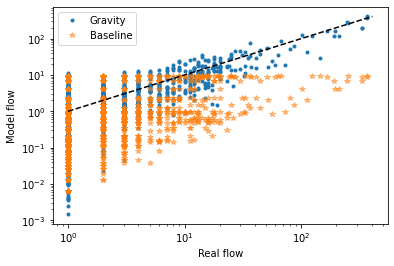

In [88]:
plt.plot(xy[:,0], xy[:,1], '.', label='Gravity')
plt.plot(xy_baseline[:,0], xy_baseline[:,1], '*', alpha=0.5, label='Baseline')
x = np.logspace(0, np.log10(np.max(xy)))
plt.plot(x, x, '--k')
plt.xlabel('Real flow'); plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog(); plt.show()

### Quantitative evaluation metrics


In [89]:
from skmob.measures.evaluation import r_squared, mse, spearman_correlation, pearson_correlation, common_part_of_commuters, common_part_of_commuters_distance

In [90]:
metrics = [r_squared, mse, spearman_correlation, pearson_correlation, common_part_of_commuters, common_part_of_commuters_distance]
names = ['r_squared', 'mse', 'spearman_correlation', 'pearson_correlation', 'common_part_of_commuters', 'common_part_of_commuters_distance']

In [91]:
print('Metric:  Gravity - Baseline')
print('---------------------------')
for i, metric in enumerate(metrics):
    m = metric(xy[:, 0], xy[:, 1])
    b = metric(xy_baseline[:, 0], xy_baseline[:, 1])
    print("%s:   %s - %s" % (names[i], np.round(m, 3), np.round(b, 3)))

Metric:  Gravity - Baseline
---------------------------
r_squared:   0.877 - 0.012
mse:   85.616 - 686.167
spearman_correlation:   [0.746 0.   ] - [0.436 0.   ]
pearson_correlation:   [0.938 0.   ] - [0.269 0.   ]
common_part_of_commuters:   0.767 - 0.291
common_part_of_commuters_distance:   0.132 - 0.101


## Exercises

**Exercise 4.1**: Download from figshare this [flows dataset](https://figshare.com/collections/Inter-urban_interactions_of_mobility_via_cellular_position_tracking_in_the_southeast_Songliao_Basin_Northeast_China/4226183), create a tessellation and a `FlowDataFrame`; plot them together using skmob. Then: 
- split the `FlowDataFrame` into a training set and a test set; 
- train a `Gravity` model on the training set
- test the model's goodness on the test set (qualitative and quantitative evaluation)